In [1]:
### FIRST THING FIRST COMES AUTHENTICATION
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 4.9MB/s 


In [2]:
fileId = drive.CreateFile({'id': '1jqjHB2QYwh7eTEqWEB5QFCcbNNkhOPXA'}) 
fileId.GetContentFile(fileId['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(fileId['title'], fileId['id']))


fileId1 = drive.CreateFile({'id': '18yJQH7ksJy4QMZ9UCMCQrApuKq93C7jw'}) 
fileId1.GetContentFile(fileId1['title'])  # Save Drive file as a local file
print('Uploaded {}, id {}'.format(fileId1['title'], fileId1['id']))

Uploaded training_data.zip, id 1jqjHB2QYwh7eTEqWEB5QFCcbNNkhOPXA
Uploaded ground_truth_data.zip, id 18yJQH7ksJy4QMZ9UCMCQrApuKq93C7jw


In [3]:
!unzip ground_truth_data
!unzip training_data

Archive:  ground_truth_data.zip
  inflating: training_sa_crop_pat5-label.nii  
  inflating: training_sa_crop_pat6-label.nii  
  inflating: training_sa_crop_pat7-label.nii  
  inflating: training_sa_crop_pat8-label.nii  
  inflating: training_sa_crop_pat9-label.nii  
  inflating: training_sa_crop_pat0-label.nii  
  inflating: training_sa_crop_pat1-label.nii  
  inflating: training_sa_crop_pat2-label.nii  
  inflating: training_sa_crop_pat3-label.nii  
  inflating: training_sa_crop_pat4-label.nii  
Archive:  training_data.zip
  inflating: training_sa_crop_pat6.nii  
  inflating: training_sa_crop_pat7.nii  
  inflating: training_sa_crop_pat8.nii  
  inflating: training_sa_crop_pat9.nii  
  inflating: training_sa_crop_pat0.nii  
  inflating: training_sa_crop_pat1.nii  
  inflating: training_sa_crop_pat2.nii  
  inflating: training_sa_crop_pat3.nii  
  inflating: training_sa_crop_pat4.nii  
  inflating: training_sa_crop_pat5.nii  


In [4]:
import os
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt_prediction
import matplotlib.pyplot as plt_maschera
from google.colab.patches import cv2_imshow
from keras import backend as K
from keras import layers
from keras.layers import Activation
from keras.layers import Input, Conv2D, ZeroPadding2D, MaxPooling2D, UpSampling2D, concatenate
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from PIL import Image
from keras.preprocessing.image import load_img
import numpy as np
import nibabel as nib
from google.colab import files
from PIL import Image
import PIL.ImageOps  
from scipy.ndimage import zoom
from keras import losses

Using TensorFlow backend.


In [10]:
img_rows = 128
img_cols = 160

array_training = np.zeros((207,128,160))
array_gt = np.zeros((207,128,160))

for x in range (10):
  img_training = nib.load('../content/training_sa_crop_pat%d.nii' % (x))
  img_gt = nib.load('../content/training_sa_crop_pat%d-label.nii' % (x))
  array_img_training = np.array(img_training.dataobj)
  array_img_gt = np.array(img_gt.dataobj)
  array_img_training=np.swapaxes(array_img_training,0,1)
  array_img_gt=np.swapaxes(array_img_gt,0,1)
  print("shape img training %d: " % (x))
  print(array_img_training.shape)
  print("shape img gt %d: " % (x))
  print(array_img_gt.shape)
  
  array_img_training = zoom(array_img_training, (1, 128/array_img_training.shape[1], 160/array_img_training.shape[2]))
  array_img_gt = zoom(array_img_gt, (1, 128/array_img_gt.shape[1], 160/array_img_gt.shape[2]))
  print("NUOVO shape img training %d: " % (x))
  print(array_img_training.shape)
  print("NUOVO shape img gt %d: " % (x))
  print(array_img_gt.shape)
  if (x == 0):
    array_training = array_img_training
    array_gt = array_img_gt
  else :
    array_training = np.concatenate((array_training, array_img_training), axis = 0)
    array_gt = np.concatenate((array_gt, array_img_gt), axis = 0)
    
print("--> shape array training finale concatenato: ")
print(array_training.shape)
print("--> shape array gt finale concatenato: ")
print(array_gt.shape)
  
array_training = array_training.reshape((array_training.shape[0], array_training.shape[1], array_training.shape[2],1))

#preprocessing delle immagini
array_training = array_training.astype('float32')
mean = np.mean(array_training)
std = np.std(array_training)

array_training -= mean
array_training /= std

shape img training 0: 
(207, 127, 151)
shape img gt 0: 
(207, 127, 151)
NUOVO shape img training 0: 
(207, 128, 160)
NUOVO shape img gt 0: 
(207, 128, 160)
shape img training 1: 
(220, 127, 160)
shape img gt 1: 
(220, 127, 160)
NUOVO shape img training 1: 
(220, 128, 160)
NUOVO shape img gt 1: 
(220, 128, 160)
shape img training 2: 
(231, 118, 190)
shape img gt 2: 
(231, 118, 190)
NUOVO shape img training 2: 
(231, 128, 160)
NUOVO shape img gt 2: 
(231, 128, 160)
shape img training 3: 
(175, 150, 148)
shape img gt 3: 
(175, 150, 148)
NUOVO shape img training 3: 
(175, 128, 160)
NUOVO shape img gt 3: 
(175, 128, 160)
shape img training 4: 
(105, 95, 130)
shape img gt 4: 
(105, 95, 130)
NUOVO shape img training 4: 
(105, 128, 160)
NUOVO shape img gt 4: 
(105, 128, 160)
shape img training 5: 
(120, 97, 164)
shape img gt 5: 
(120, 97, 164)
NUOVO shape img training 5: 
(120, 128, 160)
NUOVO shape img gt 5: 
(120, 128, 160)
shape img training 6: 
(230, 150, 170)
shape img gt 6: 
(230, 150, 1

In [0]:
# seconda rete, Alternativa alla Unet

from keras import optimizers
from keras.models import Model
from keras.layers import Dropout, Lambda
from keras.layers import Input, average
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import ZeroPadding2D, Cropping2D
from keras import backend as K


def mvn(tensor):
    '''Performs per-channel spatial mean-variance normalization.'''
    epsilon = 1e-6
    mean = K.mean(tensor, axis=(1,2), keepdims=True)
    std = K.std(tensor, axis=(1,2), keepdims=True)
    mvn = (tensor - mean) / (std + epsilon)
    
    return mvn


def crop(tensors):
    '''
    List of 2 tensors, the second tensor having larger spatial dimensions.
    '''
    h_dims, w_dims = [], []
    for t in tensors:
        b, h, w, d = K.get_variable_shape(t)
        h_dims.append(h)
        w_dims.append(w)
    crop_h, crop_w = (h_dims[1] - h_dims[0]), (w_dims[1] - w_dims[0])
    rem_h = crop_h % 2
    rem_w = crop_w % 2
    crop_h_dims = (crop_h // 2, crop_h // 2 + rem_h)
    crop_w_dims = (crop_w // 2, crop_w // 2 + rem_w)
    cropped = Cropping2D(cropping=(crop_h_dims, crop_w_dims))(tensors[1])
    
    return cropped


def dice_coef(y_true, y_pred, smooth=0.0):
    '''Average dice coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes)
    
    return K.mean((2.0 * intersection + smooth) // (summation + smooth), axis=0)


def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=10.0)


def jaccard_coef(y_true, y_pred, smooth=0.0):
    '''Average jaccard coefficient per batch.'''
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) // (union + smooth), axis=0)


def fcn_model(input_shape, num_classes, weights=None):
    ''' "Skip" FCN architecture similar to Long et al., 2015
    https://arxiv.org/abs/1411.4038
    '''
    if num_classes == 2:
        num_classes = 1
        loss = dice_coef_loss
        activation = 'sigmoid'
    else:
        loss = 'categorical_crossentropy'
        activation = 'softmax'

    kwargs = dict(
        kernel_size=3,
        strides=1,
        activation='relu',
        padding='same',
        use_bias=True,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=True,
    )
    
    data = Input(shape=input_shape, dtype='float', name='data')
    mvn0 = Lambda(mvn, name='mvn0')(data)
    pad = ZeroPadding2D(padding=5, name='pad')(mvn0)

    conv1 = Conv2D(filters=64, name='conv1', **kwargs)(pad)
    mvn1 = Lambda(mvn, name='mvn1')(conv1)
    
    conv2 = Conv2D(filters=64, name='conv2', **kwargs)(mvn1)
    mvn2 = Lambda(mvn, name='mvn2')(conv2)

    conv3 = Conv2D(filters=64, name='conv3', **kwargs)(mvn2)
    mvn3 = Lambda(mvn, name='mvn3')(conv3)
    pool1 = MaxPooling2D(pool_size=3, strides=2,
                    padding='valid', name='pool1')(mvn3)

    
    conv4 = Conv2D(filters=128, name='conv4', **kwargs)(pool1)
    mvn4 = Lambda(mvn, name='mvn4')(conv4)

    conv5 = Conv2D(filters=128, name='conv5', **kwargs)(mvn4)
    mvn5 = Lambda(mvn, name='mvn5')(conv5)

    conv6 = Conv2D(filters=128, name='conv6', **kwargs)(mvn5)
    mvn6 = Lambda(mvn, name='mvn6')(conv6)

    conv7 = Conv2D(filters=128, name='conv7', **kwargs)(mvn6)
    mvn7 = Lambda(mvn, name='mvn7')(conv7)
    pool2 = MaxPooling2D(pool_size=3, strides=2,
                    padding='valid', name='pool2')(mvn7)


    conv8 = Conv2D(filters=256, name='conv8', **kwargs)(pool2)
    mvn8 = Lambda(mvn, name='mvn8')(conv8)

    conv9 = Conv2D(filters=256, name='conv9', **kwargs)(mvn8)
    mvn9 = Lambda(mvn, name='mvn9')(conv9)

    conv10 = Conv2D(filters=256, name='conv10', **kwargs)(mvn9)
    mvn10 = Lambda(mvn, name='mvn10')(conv10)

    conv11 = Conv2D(filters=256, name='conv11', **kwargs)(mvn10)
    mvn11 = Lambda(mvn, name='mvn11')(conv11)
    pool3 = MaxPooling2D(pool_size=3, strides=2,
                    padding='valid', name='pool3')(mvn11)
    drop1 = Dropout(rate=0.5, name='drop1')(pool3)


    conv12 = Conv2D(filters=512, name='conv12', **kwargs)(drop1)
    mvn12 = Lambda(mvn, name='mvn12')(conv12)

    conv13 = Conv2D(filters=512, name='conv13', **kwargs)(mvn12)
    mvn13 = Lambda(mvn, name='mvn13')(conv13)

    conv14 = Conv2D(filters=512, name='conv14', **kwargs)(mvn13)
    mvn14 = Lambda(mvn, name='mvn14')(conv14)

    conv15 = Conv2D(filters=512, name='conv15', **kwargs)(mvn14)
    mvn15 = Lambda(mvn, name='mvn15')(conv15)
    drop2 = Dropout(rate=0.5, name='drop2')(mvn15)


    score_conv15 = Conv2D(filters=num_classes, kernel_size=1,
                        strides=1, activation=None, padding='valid',
                        kernel_initializer='glorot_uniform', use_bias=True,
                        name='score_conv15')(drop2)
    upsample1 = Conv2DTranspose(filters=num_classes, kernel_size=3,
                        strides=2, activation=None, padding='valid',
                        kernel_initializer='glorot_uniform', use_bias=False,
                        name='upsample1')(score_conv15)
    score_conv11 = Conv2D(filters=num_classes, kernel_size=1,
                        strides=1, activation=None, padding='valid',
                        kernel_initializer='glorot_uniform', use_bias=True,
                        name='score_conv11')(mvn11)
    crop1 = Lambda(crop, name='crop1')([upsample1, score_conv11])
    fuse_scores1 = average([crop1, upsample1], name='fuse_scores1')
    
    upsample2 = Conv2DTranspose(filters=num_classes, kernel_size=3,
                        strides=2, activation=None, padding='valid',
                        kernel_initializer='glorot_uniform', use_bias=False,
                        name='upsample2')(fuse_scores1)
    score_conv7 = Conv2D(filters=num_classes, kernel_size=1,
                        strides=1, activation=None, padding='valid',
                        kernel_initializer='glorot_uniform', use_bias=True,
                        name='score_conv7')(mvn7)
    crop2 = Lambda(crop, name='crop2')([upsample2, score_conv7])
    fuse_scores2 = average([crop2, upsample2], name='fuse_scores2')
    
    upsample3 = Conv2DTranspose(filters=num_classes, kernel_size=3,
                        strides=2, activation=None, padding='valid',
                        kernel_initializer='glorot_uniform', use_bias=False,
                        name='upsample3')(fuse_scores2)
    crop3 = Lambda(crop, name='crop3')([data, upsample3])
    predictions = Conv2D(filters=num_classes, kernel_size=1,
                        strides=1, activation=activation, padding='valid',
                        kernel_initializer='glorot_uniform', use_bias=True,
                        name='predictions')(crop3)
    
    model = Model(inputs=data, outputs=predictions)
    if weights is not None:
        model.load_weights(weights)
    sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss=loss,
                  metrics=['accuracy', dice_coef, jaccard_coef])

    return model



In [0]:
model = fcn_model((img_rows, img_cols, 1), 3, weights=None)

In [21]:
from keras.utils import to_categorical


# suddivisione del dataset in 70% training e 30% test
#x_train = array_training[0:1350]
#x_test = array_training[1351:1928]

#suddivisione del dataset in 7 pazienti per il training e 3 per il test
x_train = array_training[0:1288]
x_test = array_training[1288:1928]
print(x_train.shape)
print(x_test.shape)

#y_train = array_gt[0:1350]
#y_test = array_gt[1351:1928]

y_train = array_gt[0:1288]
y_test = array_gt[1288:1928]

# one hot encoding con tensorflow per 3 classi
import tensorflow as tf
n_classes = 3 
tensor=tf.one_hot(y_train, n_classes)   

#trasformaiamo il tensor in numpy array
with tf.Session() as sess:
   y_train_ohe=sess.run(tensor)

# alleniamo il modello
results = model.fit(x_train, y_train_ohe,validation_split=0.2 ,batch_size=16,epochs=3)

(1288, 128, 160, 1)
(640, 128, 160, 1)
Train on 1030 samples, validate on 258 samples
Epoch 1/3
1030/1030 [==============================] - 1605s 2s/step - loss: 0.6187 - acc: 0.7606 - dice_coef: 0.0000e+00 - jaccard_coef: 0.0000e+00 - val_loss: 0.2911 - val_acc: 0.9185 - val_dice_coef: 0.0000e+00 - val_jaccard_coef: 0.0000e+00
Epoch 2/3
1030/1030 [==============================] - 1607s 2s/step - loss: 0.2602 - acc: 0.9109 - dice_coef: 0.0000e+00 - jaccard_coef: 0.0000e+00 - val_loss: 0.3113 - val_acc: 0.9129 - val_dice_coef: 0.0000e+00 - val_jaccard_coef: 0.0000e+00
Epoch 3/3
1030/1030 [==============================] - 1733s 2s/step - loss: 0.1948 - acc: 0.9275 - dice_coef: 0.0000e+00 - jaccard_coef: 0.0000e+00 - val_loss: 0.2535 - val_acc: 0.9210 - val_dice_coef: 0.0000e+00 - val_jaccard_coef: 0.0000e+00


dict_keys(['val_loss', 'val_acc', 'val_dice_coef', 'val_jaccard_coef', 'loss', 'acc', 'dice_coef', 'jaccard_coef'])


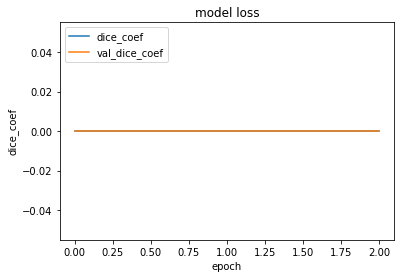

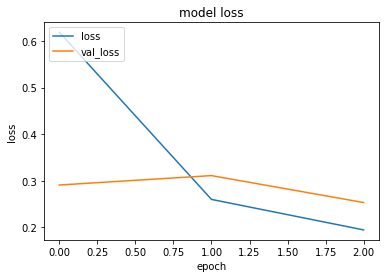

In [22]:

print(results.history.keys())

# summarize history for loss
plt.plot(results.history['dice_coef'])
plt.plot(results.history['val_dice_coef'])
plt.title('model loss')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['dice_coef', 'val_dice_coef'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()



In [0]:
import matplotlib.pyplot as plt
# testa il modello
predicted_image = model.predict(x_test, verbose = 0)

In [0]:
#funzione dice con numpy arrays
def dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
        
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum
  
  

Dice coefficient del slice: 
-->  0.9699040976460331


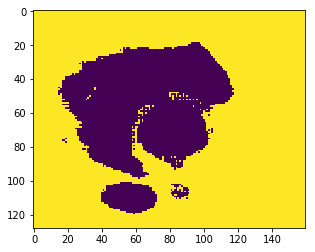

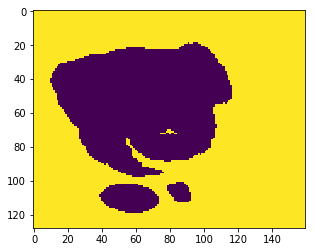

In [25]:
# risultato della predizione, slice 0 con label = 0

# round di tutti i valori della predizione
predicted_image=np.round(predicted_image,0)


image = (predicted_image[126][:, :,0] * 255.).astype(np.uint8)

test=tf.one_hot(y_test,3) 
with tf.Session() as sess:
   d=sess.run(test)
image1 = (d[126][:, :,0] * 255.).astype(np.uint8)

yy_pred=image
yy_test=image1

print("Dice coefficient del slice: ")
print("--> ",dice(yy_pred,yy_test))

img = Image.fromarray(image)  
#plot result prediction
plt_prediction.imshow(img)
plt_prediction.show()



# maschera, slice 0 con label = 0 (prima ne facciamo il one-hot-encoding)


img = Image.fromarray(image1)
plt_maschera.imshow(img)
#print ground truth
plt_maschera.show()

Dice coefficient del slice: 
-->  0.2844686648501362


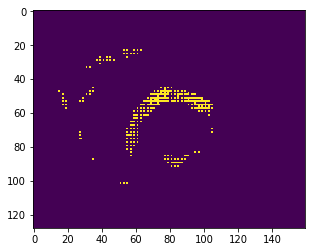

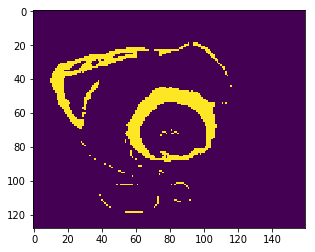

In [26]:
# risultato della predizione, slice 0 con label = 1
image = (predicted_image[126][:, :,1] * 255.).astype(np.uint8)
img = Image.fromarray(image)

test=tf.one_hot(y_test,3) 

with tf.Session() as sess:
   d=sess.run(test)
image1 = (d[126][:, :,1] * 255.).astype(np.uint8)


yy_pred=image
yy_test=image1
print("Dice coefficient del slice: ")
print("--> ",dice(yy_pred,yy_test))

plt_prediction.imshow(img)
plt_prediction.show()


# maschera, slice 0 con label = 1 (prima ne facciamo il one-hot-encoding)

img = Image.fromarray(image1)
plt_maschera.imshow(img)
plt_maschera.show()

Dice coefficient del slice: 
-->  0.9360782295419454


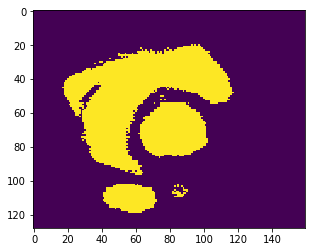

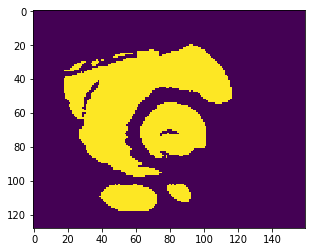

In [27]:
# risultato della predizione, slice 0 con label = 2
image = (predicted_image[126][:, :,2] * 255.).astype(np.uint8)
img = Image.fromarray(image) 


test=tf.one_hot(y_test,3) 

with tf.Session() as sess:
   d=sess.run(test)

image1 = (d[126][:, :,2] * 255.).astype(np.uint8)


yy_pred=image
yy_test=image1
print("Dice coefficient del slice: ")
print("--> ",dice(yy_pred,yy_test))


plt_prediction.imshow(img)
plt_prediction.show()


# maschera, slice 0 con label = 2 (prima ne facciamo il one-hot-encoding)

img = Image.fromarray(image1)
plt_maschera.imshow(img)
plt_maschera.show()

Dice medio per il Background:    0.9504996232008482
Deviazione standard-Background:  0.0480192522362561
--------------------->
Dice medio per il Miocardio:    0.1788601091204614
Deviazione standard-Miocardio:  0.27155191230971865
------------------------->
Dice medio per il blood Pool:    0.7074988715564181
Deviazione standard-Blood Pool:  0.30053870380896125
---------------------------->


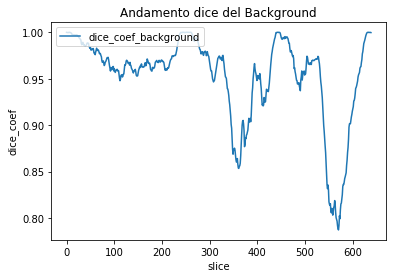

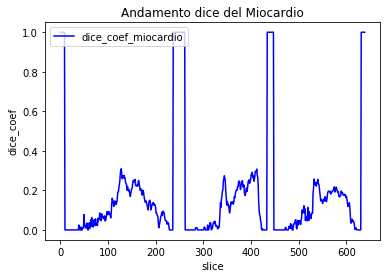

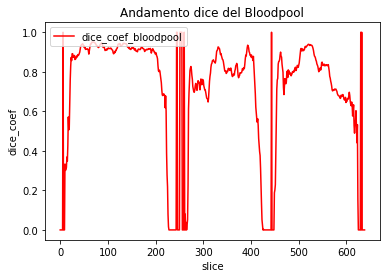

In [28]:
predicted_image=np.round(predicted_image,0)

somma = 0
array_dice_background = []

for i in range(0,639):
  image = (predicted_image[i][:, :,0] * 255.).astype(np.uint8)
  image1 = (d[i][:, :,0] * 255.).astype(np.uint8)
  yy_pred=image
  yy_test=image1
  dice_slice = dice(yy_pred,yy_test)
  somma += dice_slice
  array_dice_background.append(dice_slice)

print("Dice medio per il Background:   ", somma/640)
d_standard = np.std(array_dice_background)
print("Deviazione standard-Background: ", d_standard)


print("--------------------->")

somma = 0
array_dice_miocardio = []

for i in range(0,639):
  image = (predicted_image[i][:, :,1] * 255.).astype(np.uint8)
  image1 = (d[i][:, :,1] * 255.).astype(np.uint8)
  yy_pred=image
  yy_test=image1
  dice_slice = dice(yy_pred,yy_test)
  somma += dice_slice
  array_dice_miocardio.append(dice_slice)

print("Dice medio per il Miocardio:   ", somma/640)
deviazione_standard = np.std(array_dice_miocardio)
print("Deviazione standard-Miocardio: ", deviazione_standard)
print("------------------------->")

somma = 0
array_dice_bloodpool = []

for i in range(0,639):
  image = (predicted_image[i][:, :,2] * 255.).astype(np.uint8)
  image1 = (d[i][:, :,2] * 255.).astype(np.uint8)
  yy_pred=image
  yy_test=image1
  dice_slice = dice(yy_pred,yy_test)
  somma += dice_slice
  array_dice_bloodpool.append(dice_slice)

print("Dice medio per il blood Pool:   ", somma/640)
deviazione_standard = np.std(array_dice_bloodpool)
print("Deviazione standard-Blood Pool: ", deviazione_standard)
print("---------------------------->")

#colores = ['k','r','b','g','c','y','gray'] 

# summarize history for loss
plt.plot(array_dice_background)
plt.title('Andamento dice del Background')
plt.ylabel('dice_coef')
plt.xlabel('slice')
plt.legend(['dice_coef_background'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(array_dice_miocardio,color = 'b')
plt.title('Andamento dice del Miocardio')
plt.ylabel('dice_coef')
plt.xlabel('slice')
plt.legend(['dice_coef_miocardio'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(array_dice_bloodpool,color = 'r')
plt.title('Andamento dice del Bloodpool')
plt.ylabel('dice_coef')
plt.xlabel('slice')
plt.legend(['dice_coef_bloodpool'], loc='upper left')
plt.show()



In [0]:

def calcolo_voxel_bloodpool(array):
  print(array.shape)
  total = 0
  slices = array.shape[0]
  rows = array.shape[1]
  columns = array.shape[2]
  
  for slice in range(slices):
    for row in range(rows):
      for column in range(columns):
        print(slice,row,column)
        if (np.any(array[slice][row, column, 0] == 2)):
          total+=1
          print('voxel trovato!')
  return total
  
  
  def calcolo_voxel_bloodpool1(array):
    result = np.where(array == 2)
    print(result)
 







In [29]:
import numpy.ma as ma


prediction_paziente_7 = predicted_image[0:250]
prediction_paziente_8 = predicted_image[250:440]
prediction_paziente_9 = predicted_image[440:640]

# print(prediction_paziente_7.shape)
# print(prediction_paziente_7[0][0,0,0])
print("---------------------------->")

num_voxel_bloodpool_7 =np.sum(prediction_paziente_7[:,:,:,2])
num_voxel_bloodpool_8 =np.sum(prediction_paziente_8[:,:,:,2])
num_voxel_bloodpool_9 =np.sum(prediction_paziente_9[:,:,:,2])

#num_voxel_bloodpool_7 =np.sum(calcolo_voxel_bloodpool(prediction_paziente_7))
#num_voxel_bloodpool_8 =np.sum(calcolo_voxel_bloodpool(prediction_paziente_8))
#num_voxel_bloodpool_9 =np.sum(calcolo_voxel_bloodpool(prediction_paziente_9))


dictionary_num_voxels_prediction = {
    7 : num_voxel_bloodpool_7,
    8 : num_voxel_bloodpool_8,
    9 : num_voxel_bloodpool_9
}


for x in range (7,10):
  img_gt = nib.load('../content/training_sa_crop_pat%d-label.nii' % (x))
  dx,dy,dz= img_gt.header['pixdim'][1:4]
  
  print("valori dx,dy,dz: ",dx,dy,dz)
  
  
  volume_per_voxel=dx*dy*dz* 1e-3
  
  #numero totale di voxel
  
  num_voxel_gt =np.sum(img_gt.get_data() == 2)
  
  volume_gt = volume_per_voxel * num_voxel_gt
  
  volume_prediction = volume_per_voxel * dictionary_num_voxels_prediction[x]
  
  print("\nVolume cuore GROUND TRUE, paziente:", x)
  print("-->",volume_gt)
  print("Volume cuore PREDICTION, paziente:", x)
  print("-->",volume_prediction)
  print("Nro di voxel GROUND TRUE, paziente:", x)
  print("-->",num_voxel_gt)
  print("Nro di voxel PREDICTION, paziente:", x)
  print("-->",dictionary_num_voxels_prediction[x])
  print("---------------------------------------->")

---------------------------->
valori dx,dy,dz:  0.731061 0.731061 0.75

Volume cuore GROUND TRUE, paziente: 7
--> 445.55227017661934
Volume cuore PREDICTION, paziente: 7
--> 270.33451779770854
Nro di voxel GROUND TRUE, paziente: 7
--> 1111553
Nro di voxel PREDICTION, paziente: 7
--> 674424.0
---------------------------------------->
valori dx,dy,dz:  0.885417 0.885417 0.889999

Volume cuore GROUND TRUE, paziente: 8
--> 355.71980225539204
Volume cuore PREDICTION, paziente: 8
--> 367.49114583635327
Nro di voxel GROUND TRUE, paziente: 8
--> 509827
Nro di voxel PREDICTION, paziente: 8
--> 526698.0
---------------------------------------->
valori dx,dy,dz:  0.885417 0.885417 0.889999

Volume cuore GROUND TRUE, paziente: 9
--> 622.2150389373302
Volume cuore PREDICTION, paziente: 9
--> 441.53388075494763
Nro di voxel GROUND TRUE, paziente: 9
--> 891775
Nro di voxel PREDICTION, paziente: 9
--> 632818.0
---------------------------------------->


In [30]:
from keras.models import model_from_json
model_json = model.to_json()
with open("myfcn_weights_100.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("myfcn_weights_100.h5")
print("Saved model to disk")

Saved model to disk
